In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "MYB"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = False

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
19757,Tp6g37110,METLHPLVLSHVPTSDHRFVVQEMMQSSSWTQEENKKFERALAIYA...,273,1
15428,Pp3c5_7650V3.4.p,MQGSMTHKDISGMFTNAAPSPSGPLSPRAGSALSPGGPYTVDIRMQ...,1349,1
30157,LPERR06G21800.1,MSHHDGSKPYQPRRRPERPPPPPPPPDDAAHSGPSVDDLAAAAAAS...,358,0
8588,Gorai.010G149300.1,MGRALCGDKNGLKKGPWTPEEDKKLIDYIQKHGYGNWRTLPKNAGL...,307,1
32768,Niben101Scf04437g04001.1,MEYSSDTKATVISTSPPSSRSVSPPSSSSCSPNSPPPPPMVVVSPC...,212,0


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 19757 to 15701
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   object
 1   sequence  5000 non-null   object
 2   length    5000 non-null   int64 
 3   class     5000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 195.3+ KB


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
369,0.003891,0.001297,0.000000,0.006485,0.002594,0.006485,0.001297,0.002594,0.001297,0.003891,...,0.000000,0.001297,0.002594,0.003891,0.001297,0.005188,0.0,0.000000,0.0,0.000000
3961,0.008299,0.000000,0.008299,0.000000,0.002075,0.006224,0.000000,0.002075,0.000000,0.004149,...,0.002075,0.000000,0.002075,0.000000,0.008299,0.006224,0.0,0.002075,0.0,0.002075
366,0.018692,0.002336,0.004673,0.000000,0.004673,0.009346,0.000000,0.002336,0.000000,0.007009,...,0.000000,0.000000,0.000000,0.004673,0.000000,0.009346,0.0,0.000000,0.0,0.000000
1208,0.012245,0.000000,0.004082,0.008163,0.004082,0.004082,0.004082,0.004082,0.012245,0.004082,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4603,0.000000,0.000000,0.007143,0.014286,0.007143,0.000000,0.000000,0.000000,0.007143,0.000000,...,0.000000,0.007143,0.000000,0.000000,0.007143,0.000000,0.0,0.000000,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 440)
X_test: (1000, 440)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         112,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,161 (610.00 KB)

 Trainable params: 156,161 (610.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 21s 442ms/step - accuracy: 0.4219 - loss: 0.6933

39/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6075 - loss: 0.6814   

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6401 - loss: 0.6683 - val_accuracy: 0.9337 - val_loss: 0.3540


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9375 - loss: 0.2906

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9223 - loss: 0.2530

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9231 - loss: 0.2469 - val_accuracy: 0.9563 - val_loss: 0.1424


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0427

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9714 - loss: 0.1203

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9699 - loss: 0.1219 - val_accuracy: 0.9650 - val_loss: 0.1199


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9531 - loss: 0.0953

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9734 - loss: 0.0904

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9729 - loss: 0.0935 - val_accuracy: 0.9663 - val_loss: 0.1174


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0598

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9751 - loss: 0.0873

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9742 - loss: 0.0902 - val_accuracy: 0.9725 - val_loss: 0.1025


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0728

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.0565

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9833 - loss: 0.0594 - val_accuracy: 0.9575 - val_loss: 0.1264


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0125

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9833 - loss: 0.0523

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9827 - loss: 0.0548 - val_accuracy: 0.9625 - val_loss: 0.1168


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0190

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9827 - loss: 0.0491

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0508 - val_accuracy: 0.9700 - val_loss: 0.0992


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0186

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9835 - loss: 0.0526

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9846 - loss: 0.0488 - val_accuracy: 0.9700 - val_loss: 0.1139


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0367

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9923 - loss: 0.0336

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0319 - val_accuracy: 0.9675 - val_loss: 0.1215


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0098

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9914 - loss: 0.0300

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0303 - val_accuracy: 0.9638 - val_loss: 0.1291


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0158

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9929 - loss: 0.0307

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0290 - val_accuracy: 0.9600 - val_loss: 0.1390


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9688 - loss: 0.0595

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9926 - loss: 0.0223

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0220 - val_accuracy: 0.9638 - val_loss: 0.1354


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9688 - loss: 0.0470

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0178

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0169 - val_accuracy: 0.9725 - val_loss: 0.1309


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0031

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0262

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0253 - val_accuracy: 0.9688 - val_loss: 0.1251



[Train Accuracy: 99.22% - Test Accuracy: 96.80%]


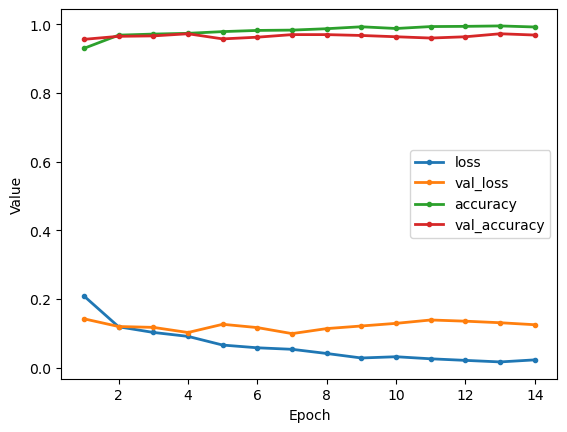

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1571,0.004274,0.0,0.0,0.000000,0.0,0.010684,0.002137,0.0,0.0,0.002137,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4399,0.000000,0.0,0.0,0.000000,0.0,0.004219,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2899,0.000000,0.0,0.0,0.006329,0.0,0.000000,0.000000,0.0,0.0,0.006329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4565,0.000000,0.0,0.0,0.009615,0.0,0.004808,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2971,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 8662)
X_test: (1000, 8662)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,217,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,260,993 (8.63 MB)

 Trainable params: 2,260,993 (8.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - accuracy: 0.3906 - loss: 0.6932

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4937 - loss: 0.6929   

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5001 - loss: 0.6925

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5055 - loss: 0.6918

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5248 - loss: 0.6899

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5469 - loss: 0.6861

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5592 - loss: 0.6827 - val_accuracy: 0.9200 - val_loss: 0.4340


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9062 - loss: 0.4479

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9384 - loss: 0.3845 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9438 - loss: 0.3414

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9481 - loss: 0.3048

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9513 - loss: 0.2776

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9537 - loss: 0.2566

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9549 - loss: 0.2466 - val_accuracy: 0.9837 - val_loss: 0.0517


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0316

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9827 - loss: 0.0471 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9848 - loss: 0.0492

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9862 - loss: 0.0463

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9868 - loss: 0.0445

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9872 - loss: 0.0432

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9874 - loss: 0.0425 - val_accuracy: 0.9850 - val_loss: 0.0469


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0092

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0086 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0125

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9978 - loss: 0.0151

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.0161

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0176

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9970 - loss: 0.0183 - val_accuracy: 0.9825 - val_loss: 0.0660


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0078

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0118 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0156

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9978 - loss: 0.0153

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0144

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0135

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0133 - val_accuracy: 0.9812 - val_loss: 0.0731


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0146

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0159 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0161

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0160

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0155

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9981 - loss: 0.0148

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0143 - val_accuracy: 0.9862 - val_loss: 0.0607


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0016

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0018 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0018

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0020

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0036

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0046

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0050 - val_accuracy: 0.9850 - val_loss: 0.0636


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0016

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0018

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0021

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0023 - val_accuracy: 0.9862 - val_loss: 0.0673


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 7.5411e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0017     

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0040

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0042

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0042

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0043

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0043 - val_accuracy: 0.9825 - val_loss: 0.0724


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 7.9027e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0010     

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.8061e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011    

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0022

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0026

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0028 - val_accuracy: 0.9825 - val_loss: 0.0777


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 4.9844e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.5395e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0696e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0012    

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0015

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0018

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.9837 - val_loss: 0.0732


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 6.0242e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.7696e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3781e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.1268e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5226e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 7.1633e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 7.3746e-04 - val_accuracy: 0.9837 - val_loss: 0.0789


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.6828e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6492e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7260e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7355e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7451e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8328e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9247e-04 - val_accuracy: 0.9850 - val_loss: 0.0804


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.4266e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4765e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2725e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1717e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0773e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0249e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9892e-04 - val_accuracy: 0.9837 - val_loss: 0.0814


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 4.0270e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3299e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9093e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7230e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6155e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5389e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5074e-04 - val_accuracy: 0.9862 - val_loss: 0.0836


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.2716e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.0669e-05 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.8310e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.1693e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.2381e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.4010e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4647e-05 - val_accuracy: 0.9862 - val_loss: 0.0861



[Train Accuracy: 100.00% - Test Accuracy: 98.50%]


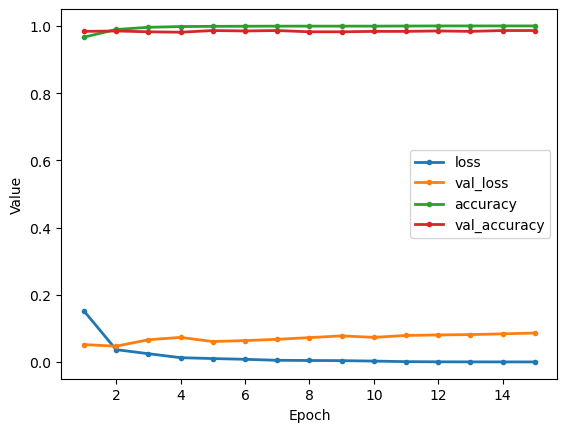

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
1571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      37,141,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,182,977 (141.84 MB)

 Trainable params: 37,182,977 (141.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 30s 630ms/step - accuracy: 0.5000 - loss: 0.6931

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.5156 - loss: 0.6931 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.5330 - loss: 0.6931

 4/50 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5404 - loss: 0.6930

 5/50 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5442 - loss: 0.6929

 6/50 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5472 - loss: 0.6928

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.5491 - loss: 0.6927

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.5493 - loss: 0.6926

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5486 - loss: 0.6925

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5482 - loss: 0.6925

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.5484 - loss: 0.6923

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5488 - loss: 0.6922

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5490 - loss: 0.6921

14/50 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.5483 - loss: 0.6920

15/50 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.5471 - loss: 0.6920

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.5455 - loss: 0.6919

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5441 - loss: 0.6919

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5428 - loss: 0.6919

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5419 - loss: 0.6918

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5418 - loss: 0.6917

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5424 - loss: 0.6916

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5435 - loss: 0.6915

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5451 - loss: 0.6914

24/50 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5471 - loss: 0.6913

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5494 - loss: 0.6911

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5519 - loss: 0.6910

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5544 - loss: 0.6908

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5570 - loss: 0.6906

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5595 - loss: 0.6904

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5621 - loss: 0.6901

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5648 - loss: 0.6899

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5676 - loss: 0.6896

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.5705 - loss: 0.6893

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.5734 - loss: 0.6890

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5764 - loss: 0.6886

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5795 - loss: 0.6882

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5825 - loss: 0.6878

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.5856 - loss: 0.6873

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5887 - loss: 0.6869

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.5918 - loss: 0.6864

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5949 - loss: 0.6858

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5980 - loss: 0.6852

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6010 - loss: 0.6846

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6041 - loss: 0.6840

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6071 - loss: 0.6832

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6102 - loss: 0.6825

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6131 - loss: 0.6817

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6160 - loss: 0.6808

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6189 - loss: 0.6800

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6218 - loss: 0.6790

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.6245 - loss: 0.6781 - val_accuracy: 0.9800 - val_loss: 0.3983


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step - accuracy: 0.9844 - loss: 0.3879

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9844 - loss: 0.3776 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9809 - loss: 0.3697

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9788 - loss: 0.3643

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9774 - loss: 0.3592

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9760 - loss: 0.3550

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9746 - loss: 0.3507

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9742 - loss: 0.3459

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9741 - loss: 0.3410

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9742 - loss: 0.3362

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9745 - loss: 0.3311

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9747 - loss: 0.3261

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9749 - loss: 0.3213

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9751 - loss: 0.3165

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9753 - loss: 0.3119

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9754 - loss: 0.3074

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9756 - loss: 0.3030

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9757 - loss: 0.2986

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9758 - loss: 0.2944

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9759 - loss: 0.2902

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9761 - loss: 0.2861

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9761 - loss: 0.2823

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9762 - loss: 0.2787

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9762 - loss: 0.2752

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9763 - loss: 0.2718

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9764 - loss: 0.2685

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9764 - loss: 0.2652

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9764 - loss: 0.2621

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9765 - loss: 0.2591

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9765 - loss: 0.2562

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9765 - loss: 0.2534

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9766 - loss: 0.2506

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9766 - loss: 0.2479

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9767 - loss: 0.2453

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9768 - loss: 0.2427

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9768 - loss: 0.2401

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9769 - loss: 0.2377

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9770 - loss: 0.2353

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9770 - loss: 0.2331

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9771 - loss: 0.2310

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9772 - loss: 0.2289

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9773 - loss: 0.2268

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9773 - loss: 0.2247

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9774 - loss: 0.2227

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9775 - loss: 0.2208

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9776 - loss: 0.2189

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9776 - loss: 0.2171

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9777 - loss: 0.2154

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9778 - loss: 0.2137

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9778 - loss: 0.2120

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9779 - loss: 0.2104 - val_accuracy: 0.9875 - val_loss: 0.0597


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.9844 - loss: 0.0458

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9883 - loss: 0.0371

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9905 - loss: 0.0325

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9919 - loss: 0.0294

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9929 - loss: 0.0270

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9936 - loss: 0.0253

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9942 - loss: 0.0239

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9944 - loss: 0.0229

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9943 - loss: 0.0227

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9942 - loss: 0.0224

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9941 - loss: 0.0223

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9941 - loss: 0.0221

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9941 - loss: 0.0219

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9941 - loss: 0.0217

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9941 - loss: 0.0214

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9942 - loss: 0.0212

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9943 - loss: 0.0209

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9943 - loss: 0.0212

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9943 - loss: 0.0215

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9944 - loss: 0.0217

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9944 - loss: 0.0218

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9945 - loss: 0.0219

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9946 - loss: 0.0219

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9946 - loss: 0.0219

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9947 - loss: 0.0219

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9947 - loss: 0.0219

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9948 - loss: 0.0220

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9948 - loss: 0.0220

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9948 - loss: 0.0220

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9948 - loss: 0.0221

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9949 - loss: 0.0221

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9949 - loss: 0.0222

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9949 - loss: 0.0223

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9949 - loss: 0.0224

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9949 - loss: 0.0225

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9949 - loss: 0.0226

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9950 - loss: 0.0227

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9950 - loss: 0.0227

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9950 - loss: 0.0228

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9950 - loss: 0.0228

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9951 - loss: 0.0228

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9951 - loss: 0.0228

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9951 - loss: 0.0228

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9951 - loss: 0.0228

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9952 - loss: 0.0228

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9952 - loss: 0.0228

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9952 - loss: 0.0228

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9952 - loss: 0.0228

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9952 - loss: 0.0228

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9952 - loss: 0.0228

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9952 - loss: 0.0228 - val_accuracy: 0.9900 - val_loss: 0.0735


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 1.0000 - loss: 0.0062

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0065

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0073

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 0.0078

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0085

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0089

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0091

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0092

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0092

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0091

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0090

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0090

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0089

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0088

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 0.0087

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0086

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 0.0085

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 0.0084

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 0.0083

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 0.0082

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 0.0081

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 0.0080

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 0.0083

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9999 - loss: 0.0085

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9999 - loss: 0.0087

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9999 - loss: 0.0088

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9999 - loss: 0.0089

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9999 - loss: 0.0090

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9999 - loss: 0.0091

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9998 - loss: 0.0092

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9998 - loss: 0.0093

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9998 - loss: 0.0093

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9998 - loss: 0.0094

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9998 - loss: 0.0094

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9998 - loss: 0.0094

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9998 - loss: 0.0095

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9997 - loss: 0.0097

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9997 - loss: 0.0099

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9997 - loss: 0.0100

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9997 - loss: 0.0101

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9997 - loss: 0.0102

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9996 - loss: 0.0103

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9996 - loss: 0.0104

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9996 - loss: 0.0105

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9996 - loss: 0.0106

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9996 - loss: 0.0106

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9996 - loss: 0.0107

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9996 - loss: 0.0108

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9995 - loss: 0.0108

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9995 - loss: 0.0108

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9995 - loss: 0.0109 - val_accuracy: 0.9850 - val_loss: 0.0510


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 1.0000 - loss: 0.0013

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0014

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0014

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0015

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0015

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 0.0015

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0015

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0015

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0015

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 0.0016

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0016

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 0.0016

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0016

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0016

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0017

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0017

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0017

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0017

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0017

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0017

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0017

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0017

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0017

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0017

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0017

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0017

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0017

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0017

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0017

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0017

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0019

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0020

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0021

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9999 - loss: 0.0022

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9999 - loss: 0.0023

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9999 - loss: 0.0024

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9999 - loss: 0.0025

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9998 - loss: 0.0026

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9998 - loss: 0.0026

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9998 - loss: 0.0028

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9998 - loss: 0.0029

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9998 - loss: 0.0030

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9997 - loss: 0.0032

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9997 - loss: 0.0033

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9997 - loss: 0.0034

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9997 - loss: 0.0035

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9997 - loss: 0.0035

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9997 - loss: 0.0036

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9996 - loss: 0.0037

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9996 - loss: 0.0038

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9996 - loss: 0.0038 - val_accuracy: 0.9837 - val_loss: 0.0579


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 1.0000 - loss: 9.7434e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.0000 - loss: 0.0010    

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.0000 - loss: 0.0011

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 0.0011

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 0.0011

 6/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 0.0012

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9997 - loss: 0.0038

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9995 - loss: 0.0055

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9993 - loss: 0.0066

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9993 - loss: 0.0073

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9992 - loss: 0.0078

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9991 - loss: 0.0082

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9991 - loss: 0.0084

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9991 - loss: 0.0085

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9991 - loss: 0.0086

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9991 - loss: 0.0087

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9991 - loss: 0.0087

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9991 - loss: 0.0087

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9991 - loss: 0.0086

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9991 - loss: 0.0086

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9991 - loss: 0.0085

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9991 - loss: 0.0085

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9991 - loss: 0.0084

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9991 - loss: 0.0085

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9991 - loss: 0.0085

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9991 - loss: 0.0086

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9991 - loss: 0.0086

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9991 - loss: 0.0086

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9991 - loss: 0.0086

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9991 - loss: 0.0086

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9991 - loss: 0.0086

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9991 - loss: 0.0085

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9991 - loss: 0.0085

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9991 - loss: 0.0085

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9991 - loss: 0.0085

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9991 - loss: 0.0084

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9991 - loss: 0.0084

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9991 - loss: 0.0084

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9991 - loss: 0.0083

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9991 - loss: 0.0083

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9991 - loss: 0.0082

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9991 - loss: 0.0082

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9991 - loss: 0.0082

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9991 - loss: 0.0081

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9991 - loss: 0.0081

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9991 - loss: 0.0080

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9991 - loss: 0.0080

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9991 - loss: 0.0079

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9991 - loss: 0.0079

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9991 - loss: 0.0078

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9991 - loss: 0.0078 - val_accuracy: 0.9875 - val_loss: 0.0506


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 8.6867e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 8.1157e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 7.9964e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 8.1212e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 8.0629e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 8.0117e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.0058e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.0517e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.2823e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.5016e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.6455e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 8.7480e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.8004e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 8.8288e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 8.8380e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.8339e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.8214e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.8056e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.7855e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.7595e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.7290e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.7046e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.6871e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 8.6704e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 8.6507e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 8.6294e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 8.6070e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0010    

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0011

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9999 - loss: 0.0013

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9999 - loss: 0.0014

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9999 - loss: 0.0015

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9999 - loss: 0.0015

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9999 - loss: 0.0016

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9999 - loss: 0.0017

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9999 - loss: 0.0018

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9999 - loss: 0.0018

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9999 - loss: 0.0019

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9998 - loss: 0.0020

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9998 - loss: 0.0022

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9998 - loss: 0.0022

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9998 - loss: 0.0023

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9998 - loss: 0.0024

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9998 - loss: 0.0025

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9998 - loss: 0.0026

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9997 - loss: 0.0026

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9997 - loss: 0.0027

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9997 - loss: 0.0027

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9997 - loss: 0.0028

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9997 - loss: 0.0028

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9997 - loss: 0.0029 - val_accuracy: 0.9837 - val_loss: 0.0567


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 1.0000 - loss: 4.8428e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 5.3553e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 5.7172e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9990 - loss: 0.0050    

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9986 - loss: 0.0069

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9984 - loss: 0.0078

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9983 - loss: 0.0083

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9983 - loss: 0.0084

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9981 - loss: 0.0094

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9980 - loss: 0.0100

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9979 - loss: 0.0104

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9978 - loss: 0.0106

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9978 - loss: 0.0107

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9978 - loss: 0.0108

15/50 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9978 - loss: 0.0108

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9978 - loss: 0.0108

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9979 - loss: 0.0107

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9979 - loss: 0.0106

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9979 - loss: 0.0105

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9979 - loss: 0.0104

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9980 - loss: 0.0103

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9980 - loss: 0.0102

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9980 - loss: 0.0101

24/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9980 - loss: 0.0099

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9981 - loss: 0.0098

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9981 - loss: 0.0097

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9981 - loss: 0.0096

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9982 - loss: 0.0095

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9982 - loss: 0.0094

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9982 - loss: 0.0092

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9982 - loss: 0.0091

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9983 - loss: 0.0090

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9983 - loss: 0.0089

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9983 - loss: 0.0088

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9983 - loss: 0.0087

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9984 - loss: 0.0086

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9984 - loss: 0.0085

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9984 - loss: 0.0084

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9984 - loss: 0.0083

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9984 - loss: 0.0082

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9985 - loss: 0.0081

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9985 - loss: 0.0080

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9985 - loss: 0.0079

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9985 - loss: 0.0079

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9985 - loss: 0.0078

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9985 - loss: 0.0077

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9986 - loss: 0.0076

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9986 - loss: 0.0075

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9986 - loss: 0.0075

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9986 - loss: 0.0074

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9986 - loss: 0.0073 - val_accuracy: 0.9875 - val_loss: 0.0530


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 1.0000 - loss: 4.0904e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.8131e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 3.8843e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 4.1183e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 4.2755e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 4.4075e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 4.4786e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 4.5066e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 4.5047e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 4.5173e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 4.5248e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 4.5343e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 4.5375e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 4.5310e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 4.5184e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 4.5009e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 4.4828e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 4.4653e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.4507e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 4.4373e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.4223e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.4063e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.3906e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 4.3763e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 5.5295e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 6.5491e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9999 - loss: 7.4536e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9999 - loss: 9.3155e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9999 - loss: 0.0011    

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9998 - loss: 0.0012

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9998 - loss: 0.0014

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9998 - loss: 0.0015

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9998 - loss: 0.0016

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9997 - loss: 0.0017

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9997 - loss: 0.0018

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9997 - loss: 0.0019

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9997 - loss: 0.0020

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9997 - loss: 0.0020

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9997 - loss: 0.0021

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9997 - loss: 0.0022

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9996 - loss: 0.0022

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9996 - loss: 0.0023

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9996 - loss: 0.0023

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9996 - loss: 0.0023

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9996 - loss: 0.0024

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9996 - loss: 0.0024

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9996 - loss: 0.0024

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9996 - loss: 0.0025

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9996 - loss: 0.0025

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9996 - loss: 0.0025

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9996 - loss: 0.0025 - val_accuracy: 0.9825 - val_loss: 0.0633


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 1.0000 - loss: 0.0010

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 8.7265e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 8.2801e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 7.8714e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 7.5578e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 7.3028e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 7.0534e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 6.8669e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 6.6996e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 6.5461e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 6.4174e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 6.2997e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 6.1846e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 6.0796e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 5.9804e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 5.8908e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 5.8052e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 5.7262e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 5.6542e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 5.5865e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 5.5240e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 5.4648e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 5.4090e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 5.3596e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 5.3105e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 5.2651e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 5.2221e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 5.1825e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 5.1455e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 5.1099e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 5.0746e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 5.0399e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.0070e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.9754e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.0635e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.1433e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.2157e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.2810e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.3409e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.3943e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.4419e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 5.4851e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 5.5242e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 5.5598e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 5.5924e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 5.6211e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 5.6464e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 5.6711e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 5.6931e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.7125e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 5.7311e-04 - val_accuracy: 0.9825 - val_loss: 0.0647


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 1.0000 - loss: 3.4743e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.0000 - loss: 4.1439e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 4.0801e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 4.1618e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 4.1200e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 4.0390e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 3.9525e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 3.8760e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 3.8030e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 3.7266e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 3.6592e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 3.6031e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 3.5603e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 3.5206e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 3.4812e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 3.4502e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 3.4206e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 3.3973e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 3.3715e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 3.3537e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 3.3355e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 3.3173e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 3.2986e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 3.2801e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 3.2824e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 3.2826e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 3.2831e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 3.2829e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 3.2816e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 3.2795e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 3.2785e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 3.2761e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 3.2721e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.2674e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.2622e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.2564e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.2675e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.2784e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.2874e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.2949e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.3012e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 3.3066e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 3.3109e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.3143e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.3165e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.3179e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.3185e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.3184e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.3182e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.3174e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.3167e-04 - val_accuracy: 0.9887 - val_loss: 0.0617


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 1.0000 - loss: 2.4817e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 2.2873e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 2.1293e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 2.0436e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 1.9724e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 1.9193e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 1.8745e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.8351e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.8952e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.9316e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.9584e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.9738e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.9807e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.9821e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.9785e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.9764e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.9722e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.9655e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.9598e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.9592e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.9578e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.9548e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.9505e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.9479e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.9457e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.9438e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.9416e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.9383e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.9356e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.9317e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.9690e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.0036e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 2.0352e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 2.0634e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 2.0884e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 2.1106e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 2.1307e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 2.1492e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 2.1659e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 2.1823e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 2.1966e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.2094e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.2207e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.2316e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.2411e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.2501e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.2581e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.2649e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.2707e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.2757e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.2805e-04 - val_accuracy: 0.9875 - val_loss: 0.0639


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.1637e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 1.0000 - loss: 1.0905e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 1.0000 - loss: 1.0331e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 1.0000 - loss: 1.0791e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 1.0810e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.1158e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 1.1355e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 1.1421e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.1452e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 1.1433e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.1393e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.1354e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.1318e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.1313e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.1368e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.1413e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.1446e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.1464e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.1471e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.1475e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.1478e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.1478e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.1483e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.1616e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.1731e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.1832e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.1919e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.1997e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.2065e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.2125e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.2173e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.2216e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.2262e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.2308e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.2354e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.2395e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.2434e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.2495e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.2551e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.2599e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.2644e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.2685e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.2720e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.2748e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.2771e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.2790e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.2808e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.2822e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.2833e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.2840e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.2847e-04 - val_accuracy: 0.9887 - val_loss: 0.0646



[Train Accuracy: 100.00% - Test Accuracy: 98.20%]


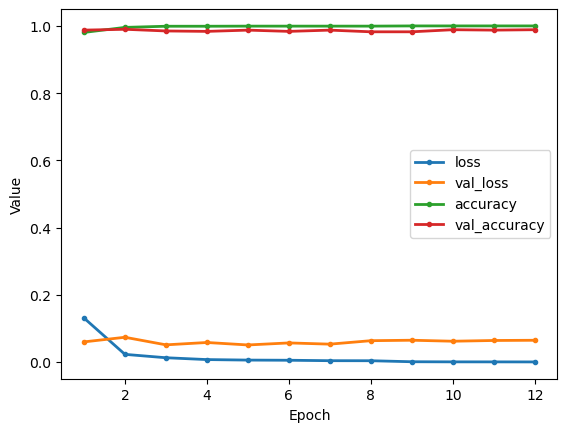

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

12/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [26]:
report.save()

Report saved as Output/Reports/MYB/report_O47VICNX.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [28]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [30]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [31]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [32]:
# END

In [33]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################